# Projet SY09 - Bigfoot

* transformer les textes (observed, location_details, title, summary) en catégories de mots clés (ajout de colonnes) (feature engineering -> https://www.kdnuggets.com/2018/12/feature-engineering-explained.html)
* https://www.kdnuggets.com/2018/12/feature-building-techniques-tricks-kaggle.html
* https://www.kaggle.com/code/dextermojo/eda-with-kmeans-and-famd
* https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b
* https://developers.google.com/machine-learning/data-prep/transform/normalization?hl=en
* https://maxhalford.github.io/prince/famd/

## Import des bibiliothèques

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans

from utils import plot_dendrogram, scatterplot_pca

## Chargement du jeu de données

In [2]:
# importer données du fichier csv
bigfoot = pd.read_csv("../data/bigfoot.csv", sep = ",")

### Mise en forme du jeu de données
#### Ajout et suppression de colonnes

In [3]:
# ajoute des colonnes jour, mois, année=
year = bigfoot['date'].copy()
month = bigfoot['date'].copy()
day = bigfoot['date'].copy()

for i in range(bigfoot['date'].size):
    d = bigfoot['date'][i]
    if str(d) != "nan":
        d_datetime = datetime.strptime(str(d),'%Y-%m-%d')
        year[i] = d_datetime.year
        month[i] = d_datetime.month
        day[i] = d_datetime.day

bigfoot = bigfoot.assign(year = year)
bigfoot = bigfoot.assign(month = month)
bigfoot = bigfoot.assign(day = day)

bigfoot.drop(columns="geohash", inplace=True)
bigfoot.drop(columns="date", inplace=True)

#### Conversion d'unité et mise en forme des données

In [4]:
# temperature_high : fahrenheit en celsius
# temperature_mid : fahrenheit en celsius
# temperature_low : fahrenheit en celsius
# dew_point : fahrenheit en celsius
# wind_speed : miles par heure en kilomètre par heure
# precip_intensity : inch en cm
# visibility : miles en kilomètre
# latitude / longitude : coordonnées polaires

bigfoot = bigfoot.assign(
    temperature_high = (bigfoot.temperature_high - 32) * 5 / 9,
    temperature_mid = (bigfoot.temperature_mid - 32) * 5 / 9,
    temperature_low = (bigfoot.temperature_low - 32) * 5 / 9,
    dew_point = (bigfoot.dew_point - 32) * 5 / 9,
    wind_speed = bigfoot.wind_speed * 1.609344,
    precip_intensity = bigfoot.precip_intensity * 2.54,
    visibility = bigfoot.visibility * 1.609344,
    r = np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 ),
    theta = 2 * np.arctan( bigfoot.latitude / ( bigfoot.longitude + np.sqrt(bigfoot.longitude ** 2 + bigfoot.latitude ** 2 )))
)

# pour le "titre" garde la partie [titre] du format inital “Report [numéro] : [titre]”

bigfoot = bigfoot.assign(
    title = bigfoot.title.str.replace(r'^Report \d*: ', '')
)

# transformation de precip_type en deux colonnes snow et rain
bigfoot["rain"] = 0.0
bigfoot.loc[bigfoot.precip_type == "rain", "rain"] = 1.0
bigfoot["snow"] = 0.0
bigfoot.loc[bigfoot.precip_type == "snow", "snow"] = 1.0
bigfoot["summer"] = 0.0
bigfoot.loc[bigfoot.season == "Summer", "summer"] = 1.0
bigfoot["spring"] = 0.0
bigfoot.loc[bigfoot.season == "Spring", "spring"] = 1.0
bigfoot["fall"] = 0.0
bigfoot.loc[bigfoot.season == "Fall", "fall"] = 1.0
bigfoot["winter"] = 0.0
bigfoot.loc[bigfoot.season == "Winter", "winter"] = 1.0

/tmp/ipykernel_31381/2260502135.py:25: FutureWarning: The default value of regex will change from True to False in a future version.
  title = bigfoot.title.str.replace(r'^Report \d*: ', '')


#### Conversion des types

In [5]:
# dictionnaire des états des Etats-Unis et leur abbrévation

us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
}

In [6]:
# variables catégorielles

bigfoot.county = pd.Categorical(bigfoot.county)
bigfoot.state = pd.Categorical(bigfoot.state, categories=us_state_to_abbrev.keys())

bigfoot.classification = bigfoot.classification.replace("Class A", "A")
bigfoot.classification = bigfoot.classification.replace("Class B", "B")
bigfoot.classification = bigfoot.classification.replace("Class C", "C")
bigfoot.classification = pd.Categorical(bigfoot.classification, categories=["A", "B", "C"], ordered=True)

bigfoot.drop(columns=["precip_type"], inplace=True)
bigfoot.drop(columns=["season"], inplace=True)

In [7]:
# types des variables

# Attention! Conséquence, variables catégorielles ont des valeurs <NA> à la place de NaN.

bigfoot.observed = bigfoot.observed.astype('string')
bigfoot.location_details = bigfoot.location_details.astype('string')
bigfoot.title = bigfoot.title.astype('string')
bigfoot.summary = bigfoot.summary.astype('string')

bigfoot.number = bigfoot.number.astype('Int64')

bigfoot.day = bigfoot.day.astype(float)
bigfoot.month = bigfoot.month.astype(float)
bigfoot.year = bigfoot.year.astype(float)

### Conversion des variables et corrélations

In [8]:
features = [
    'r',
    'theta',
    'temperature_high',
    'temperature_mid',
    'temperature_low',
    'dew_point',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

<AxesSubplot: >

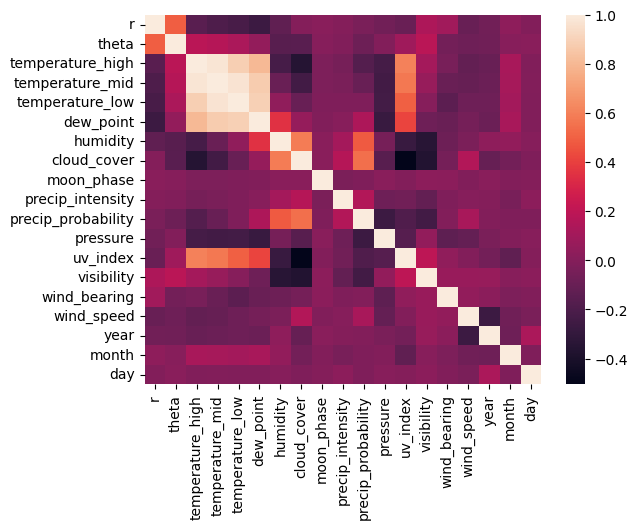

In [9]:
corr = bigfoot[features].corr()
sns.heatmap(corr)

In [10]:
bigfoot.drop(columns=["temperature_high", "temperature_low", "dew_point"], inplace=True)

features = [
    'summer',
    'winter',
    'fall',
    'spring',
    'r',
    'theta',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'rain',
    'snow',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
    ]

numeric_cols = [
    'r',
    'theta',
    'temperature_mid',
    'humidity',
    'cloud_cover',
    'moon_phase',
    'precip_intensity',
    'precip_probability',
    'pressure',
    'uv_index',
    'visibility',
    'wind_bearing',
    'wind_speed',
    'year',
    'month',
    'day'
]

cat_cols = [
    'summer',
    'winter',
    'fall',
    'spring',
    'rain',
    'snow'
]

## FAMD (Factorial Analysis of Mixed Data)

In [11]:
def fill_missing(df):
    '''
    replace empty values by column's mean in dataframe
    '''
    return df.copy().fillna(df.mean())

In [12]:
def calculate_zscore(df):
    '''
    scales columns in dataframe using z-score
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

    return df

In [13]:
def normalize_column_modality(df):
    '''
    divides each column by the probability μₘ of the modality 
    (number of ones in the column divided by N) only for one hot columns
    '''
    df = df.copy()
    length = len(df)
    for col in df.columns:
        weight = math.sqrt(sum(df[col])/length)
        df[col] = df[col]/weight

    return df

In [14]:
def center_columns(df):
    '''
    center columns by subtracting the mean value
    '''
    df = df.copy()
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())
    return df

In [15]:
bigfoot_famd_num = pd.DataFrame(calculate_zscore(fill_missing(bigfoot[numeric_cols])))
bigfoot_famd_cat = center_columns(normalize_column_modality(bigfoot[cat_cols]))
bigfoot_famd = pd.concat([bigfoot_famd_num, bigfoot_famd_cat], axis=1)
bigfoot_famd

,r,theta,temperature_mid,humidity,cloud_cover,moon_phase,precip_intensity,precip_probability,pressure,uv_index,...,wind_speed,year,month,day,summer,winter,fall,spring,rain,snow
0,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,1.030136,-0.385197,-0.545116,-0.405352,-0.557757,-0.179068
1,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,-0.609785,-0.385197,1.289354,-0.405352,-0.557757,-0.179068
2,-1.511516,-2.641669,1.193163,1.172414,1.613579e+00,-1.425538,-1.549729e-01,-0.963198,7.953582e-01,-4.505533e-01,...,1.131921e+00,-1.897989e+00,0.638602,7.341114e-01,-0.609785,-0.385197,1.289354,-0.405352,-0.557757,-0.179068
3,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,1.030136,-0.385197,-0.545116,-0.405352,-0.557757,-0.179068
4,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,-0.609785,-0.385197,-0.545116,2.061643,-0.557757,-0.179068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5016,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,1.030136,-0.385197,-0.545116,-0.405352,-0.557757,-0.179068
5017,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,-0.609785,-0.385197,-0.545116,2.061643,-0.557757,-0.179068
5018,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,1.030136,-0.385197,-0.545116,-0.405352,-0.557757,-0.179068
5019,0.000000,0.000000,0.000000,0.000000,-2.127501e-16,0.000000,1.854166e-17,0.000000,-5.124764e-14,-3.446008e-16,...,2.045549e-16,-1.731932e-14,0.000000,2.305848e-16,-0.609785,-0.385197,1.289354,-0.405352,-0.557757,-0.179068


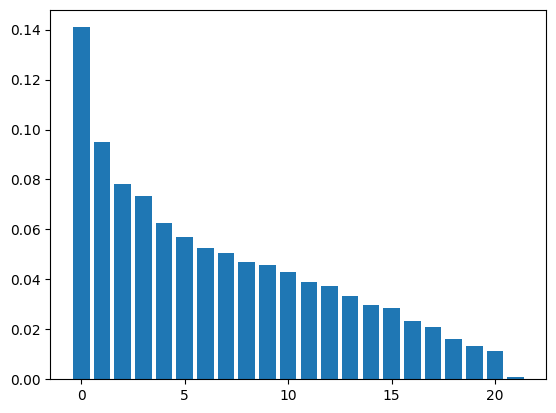

In [16]:
cls = PCA()
pcs = cls.fit_transform(bigfoot_famd)
plt.bar(range(cls.components_.shape[0]), cls.explained_variance_ratio_)
plt.show()

In [17]:
eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(cls.explained_variance_.size)], 
        "Variance expliquée" : cls.explained_variance_,
        "% variance expliquée" : np.round(cls.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(cls.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,2.914258,14.0,14.0
1,Dim2,1.961438,9.0,24.0
2,Dim3,1.617762,8.0,31.0
3,Dim4,1.517402,7.0,39.0
4,Dim5,1.293333,6.0,45.0
5,Dim6,1.181601,6.0,51.0
6,Dim7,1.087785,5.0,56.0
7,Dim8,1.047921,5.0,61.0
8,Dim9,0.969183,5.0,66.0
9,Dim10,0.950108,5.0,70.0


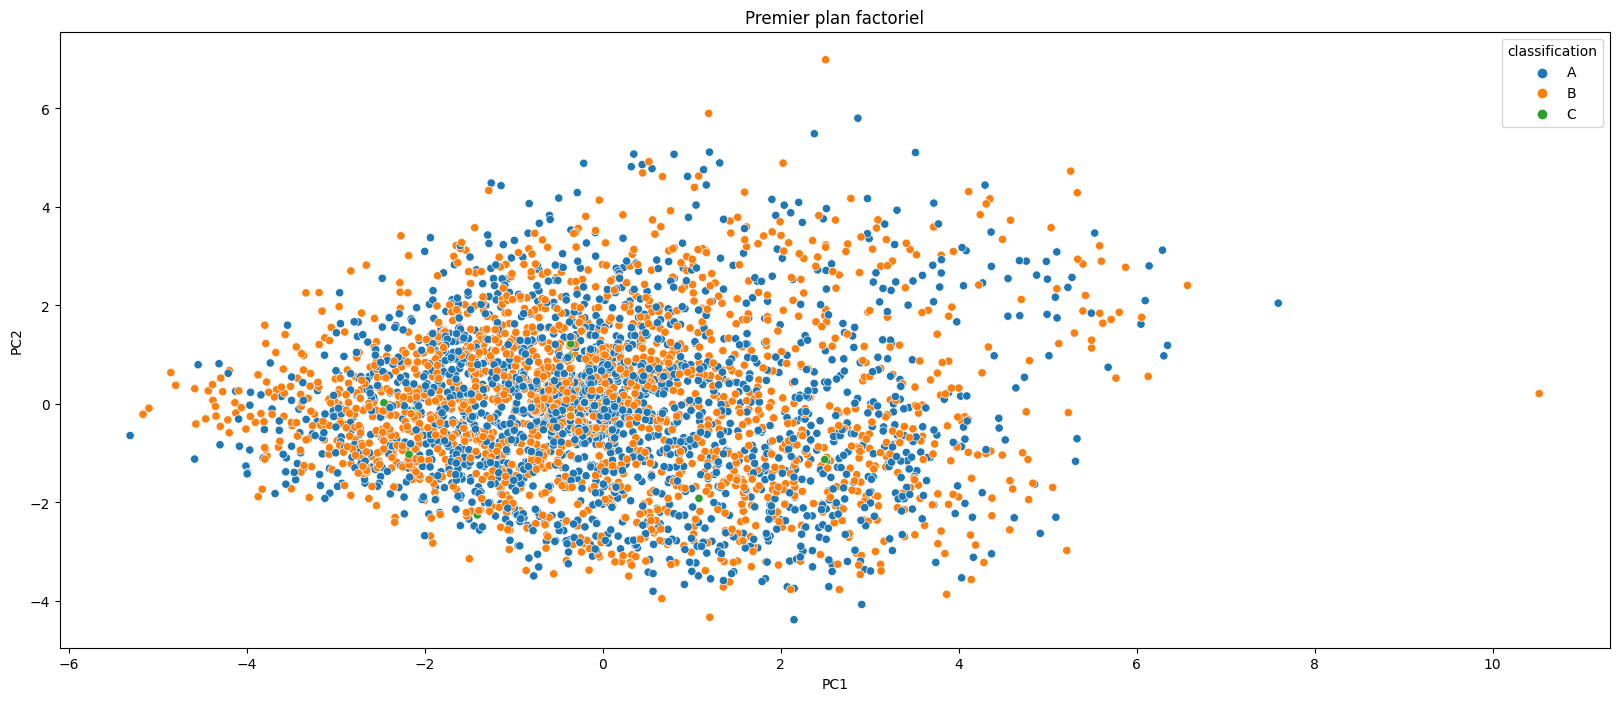

In [18]:
plt.figure(figsize=(20,8))
df_X = pd.DataFrame(pcs, columns=[f"PC{i+1}" for i in range(cls.components_.shape[0])])
# sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X) # pas le même résultat que la ligne du dessous : lequel prendre ?
sns.scatterplot(x="PC1", y="PC2", hue=bigfoot.classification, data=df_X)
plt.title("Premier plan factoriel")
plt.show()

In [19]:
n = bigfoot_famd.shape[0] # nb individus
p = bigfoot_famd.shape[1] # nb variables
eigval = (n-1) / n * cls.explained_variance_ # valeurs propres
sqrt_eigval = np.sqrt(eigval) # racine carrée des valeurs propres
corvar = np.zeros((p,p)) # matrice vide pour avoir les coordonnées
for k in range(p):
    corvar[:,k] = cls.components_[k,:] * sqrt_eigval[k]
# on modifie pour avoir un dataframe
coordvar = pd.DataFrame({'id': features, 'COR_1': corvar[:,0], 'COR_2': corvar[:,1]})
coordvar

,id,COR_1,COR_2
0,summer,-0.113390,0.209046
1,winter,-0.306236,0.077264
2,fall,-0.529069,-0.655800
3,spring,0.667818,-0.287025
4,r,0.763745,-0.227969
5,theta,-0.004217,0.046235
6,temperature_mid,0.189118,-0.069305
7,humidity,0.623231,-0.468911
8,cloud_cover,-0.038003,0.521022
9,moon_phase,-0.657416,-0.438979


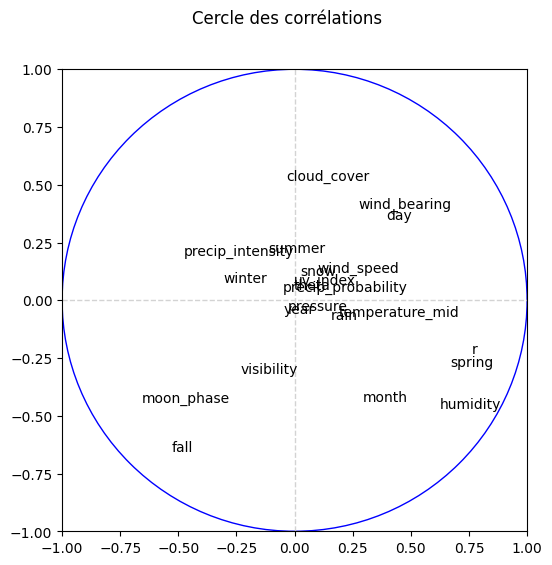

In [20]:
# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize = (6,6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)
# Ajout des axes
axes.axvline(x = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
axes.axhline(y = 0, color = 'lightgray', linestyle = '--', linewidth = 1)
# Ajout des noms des variables
for j in range(p):
    axes.text(coordvar["COR_1"][j],coordvar["COR_2"][j], coordvar["id"][j])
# Ajout du cercle
plt.gca().add_artist(plt.Circle((0,0),1,color='blue',fill=False))

plt.show()

## CAH

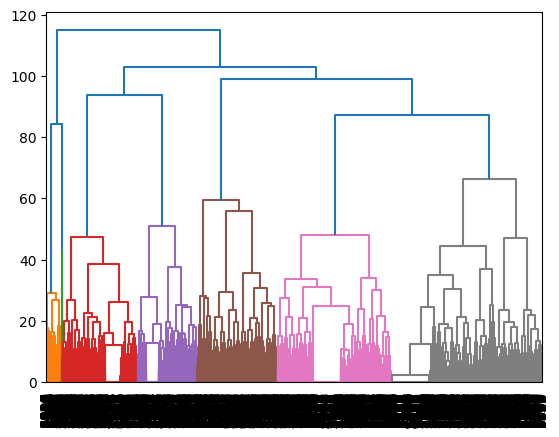

In [21]:
cls = AgglomerativeClustering(linkage="ward", metric="euclidean", distance_threshold=0, n_clusters=None)
cls.fit(bigfoot_famd)
plot_dendrogram(cls)

## K-means

In [22]:
kmeans3 = KMeans(n_clusters = 3)
kmeans3.fit(bigfoot_famd)
pd.Series(kmeans3.labels_).value_counts()

/home/miguella/.pyenv/versions/3.9.10/envs/SY09/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    3779
2    1081
1     161
dtype: int64

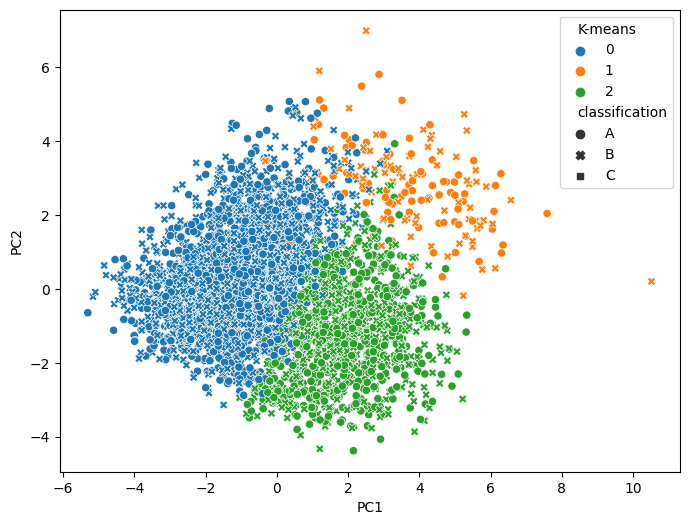

In [23]:
plt.figure(figsize=(8,6))
labels = pd.Series(kmeans3.labels_, name="K-means")
ax, _ = scatterplot_pca(data=bigfoot_famd, hue=labels, style=bigfoot.classification)
plt.show()
fig = ax.get_figure()

In [24]:
bigfoot_k3 = bigfoot_famd.assign(classe_kmean = kmeans3.labels_)
bigfoot_k3.groupby("classe_kmean").mean()

,r,theta,temperature_mid,humidity,cloud_cover,moon_phase,precip_intensity,precip_probability,pressure,uv_index,...,wind_speed,year,month,day,summer,winter,fall,spring,rain,snow
classe_kmean,,,,,,,,,,,,,,,,,,,,,
0,0.035533,0.094942,0.113482,-0.280053,-0.325475,0.010700,-0.064944,-0.407631,0.101287,0.179187,...,-0.067925,-0.077452,0.015664,-0.008003,0.043319,-0.045145,-0.014047,-0.003216,-0.304883,-0.179068
1,-0.070234,-0.592899,-2.168679,0.586433,0.720965,-0.043041,0.504778,0.806209,0.298122,-1.207246,...,0.368599,0.284480,-0.572167,0.036697,-0.456998,0.888653,0.047383,-0.221476,-0.557757,5.405405
2,-0.113757,-0.243597,-0.073721,0.891679,1.030431,-0.030995,0.151856,1.304937,-0.398486,-0.446605,...,0.182557,0.228391,0.030459,0.022511,-0.083372,0.025468,0.042050,0.044230,1.148892,-0.179068
